In [1]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
import ale_py
import shimmy

# Hyperparameters
ENV_NAME = "ALE/MsPacman-v5"
LEARNING_RATE = 1e-4
GAMMA = 0.99
BUFFER_SIZE = 100000
BATCH_SIZE = 32
EPSILON_START = 1.0
EPSILON_MIN = 0.1
EPSILON_DECAY = 0.995
TARGET_UPDATE = 10
EPISODES = 500
MAX_STEPS = 10000

In [2]:
# Neural Network for the Q-function
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(input_dim[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
        )

        with torch.no_grad():
            dummy_input = torch.zeros(1, *input_dim)
            conv_output = self.conv(dummy_input)
            self.conv_output_size = conv_output.numel()

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.conv_output_size, 512),
            nn.ReLU(),
            nn.Linear(512, output_dim)
        )

    def forward(self, x):
        x = self.conv(x / 255.0)
        return self.fc(x)

# Replay buffer for experience replay
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def size(self):
        return len(self.buffer)

# Agent class
class DQNAgent:
    def __init__(self, state_shape, n_actions):
        self.n_actions = n_actions
        self.epsilon = EPSILON_START
        self.policy_net = DQN(state_shape, n_actions)
        self.target_net = DQN(state_shape, n_actions)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=LEARNING_RATE)
        self.replay_buffer = ReplayBuffer(BUFFER_SIZE)

    def select_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.n_actions)
        else:
            state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
            q_values = self.policy_net(state)
            return torch.argmax(q_values).item()

    def train(self):
        if self.replay_buffer.size() < BATCH_SIZE:
            return 0  # Return 0 if not enough data to train

        batch = self.replay_buffer.sample(BATCH_SIZE)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.tensor(np.array(states), dtype=torch.float32)
        actions = torch.tensor(actions, dtype=torch.long).unsqueeze(1)
        rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(1)
        next_states = torch.tensor(np.array(next_states), dtype=torch.float32)
        dones = torch.tensor(dones, dtype=torch.float32).unsqueeze(1)

        q_values = self.policy_net(states).gather(1, actions)
        next_q_values = self.target_net(next_states).max(1)[0].unsqueeze(1)
        target_q_values = rewards + (1 - dones) * GAMMA * next_q_values

        loss = nn.MSELoss()(q_values, target_q_values)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss.item()

    def evaluate_q_values(self, state):
        """
        Evaluate Q-values for a given state using the policy network.
        Args:
            state: The current state (numpy array).
        Returns:
            Q-values as a numpy array.
        """
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)  # Add batch dimension
        with torch.no_grad():  # No gradient computation for evaluation
            q_values = self.policy_net(state)
        return q_values.squeeze(0).numpy()  # Return as a 1D numpy array

    def update_target_net(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())


In [3]:
def compute_custom_rewards(state, reward, done, agent_type, info=None, last_action=None, current_action=None):
    """
    Compute custom rewards based on the state, reward, and agent type.

    :param state: Current state of the environment.
    :param reward: Default reward from the environment.
    :param done: Whether the episode is done.
    :param agent_type: Type of the agent ('pacman' or 'ghost').
    :param info: Additional information from the environment (optional).
    :param last_action: The last action taken by the agent.
    :param current_action: The current action taken by the agent.
    :return: Custom reward for the agent.
    """
    custom_reward = reward

    if agent_type == 'pacman':
        if reward > 0:
            custom_reward += 10  # Bonus for eating dots or pellets
        if done and reward > 0:
            custom_reward += 50  # Bonus for successfully clearing a level
        
        # Negative reward for encountering a ghost
        if info and 'ghost_collision' in info and info['ghost_collision']:
            custom_reward -= 100

        # Slight penalty for repeated motions
        if last_action is not None and current_action == last_action:
            custom_reward -= 1  # Penalize repeated actions slightly

    elif agent_type == 'ghost':
        custom_reward = -reward  # Ghosts minimize Pacman's reward

        # Bonus for catching Pacman
        if info and 'ghost_collision' in info and info['ghost_collision']:
            custom_reward += 100

        # Encourage chasing Pacman if close
        if info and 'distance_to_pacman' in info and info['distance_to_pacman'] < 5:
            custom_reward += 10

    return custom_reward

class FrameSkip(gym.Wrapper):
    def __init__(self, env, skip=4):
        """
        Return only every `skip`-th frame.
        :param env: Environment to wrap.
        :param skip: Number of frames to skip.
        """
        super().__init__(env)
        self.skip = skip

    def step(self, action):
        """
        Repeat an action for `skip` frames.
        """
        total_reward = 0.0
        done = False
        truncated = False
        for _ in range(self.skip):
            obs, reward, done, truncated, info = self.env.step(action)
            total_reward += reward
            if done or truncated:
                break
        return obs, total_reward, done, truncated, info
    

In [4]:
import time

def is_collision(state, reward, done):
    """
    Detect collision in MsPacman using rewards or done flag.
    Args:
        state: Current observation (not directly used here).
        reward: Immediate reward from the environment.
        done: Whether the episode has ended.
    Returns:
        Boolean indicating if a collision occurred.
    """
    # Collision with ghost (Pacman dies)
    if done and reward <= 0:
        return True
    
    # Collision where Pacman eats a ghost (positive reward)
    if reward > 0:
        return True

    return False

def train_with_metrics():
    env = gym.make(ENV_NAME, render_mode=None)
    env = FrameSkip(env, skip=4)
    state_shape = env.observation_space.shape
    state_shape = (state_shape[2], state_shape[0], state_shape[1])
    n_actions = env.action_space.n

    pacman_agent = DQNAgent(state_shape, n_actions)
    ghost_agent = DQNAgent(state_shape, n_actions)

    # Metrics
    pacman_rewards = []
    ghost_rewards = []
    pacman_losses = []
    ghost_losses = []
    epsilons = []
    episode_lengths = []
    success_rates = []
    q_values_pacman = []
    q_values_ghost = []
    wall_clock_times = []
    total_steps = 0
    collisions = 0 
    collisions_per_episode = []
    action_counts_pacman = [0] * n_actions
    action_counts_ghost = [0] * n_actions

    for episode in range(EPISODES):
        start_time = time.time()  # Track wall-clock time

        state, _ = env.reset()
        total_reward_pacman = 0
        total_reward_ghost = 0
        state = np.moveaxis(state, -1, 0)

        pacman_loss = 0
        ghost_loss = 0
        steps = 0
        episode_collisions = 0  # NEW: Initialize collisions for this episode

        for step in range(MAX_STEPS):
            # Pacman action
            pacman_action = pacman_agent.select_action(state)
            action_counts_pacman[pacman_action] += 1  # Count actions
            next_state, reward, done, _, _ = env.step(pacman_action)

            # Compute custom rewards
            pacman_reward = compute_custom_rewards(state, reward, done, agent_type='pacman')

            # Ghost action
            ghost_action = ghost_agent.select_action(state)
            action_counts_ghost[ghost_action] += 1  # Count actions
            ghost_reward = compute_custom_rewards(state, reward, done, agent_type='ghost')

            next_state = np.moveaxis(next_state, -1, 0)

            # Check for collisions/interactions
            if is_collision(state, reward, done):  # Replace with collision detection logic
                collisions += 1
                episode_collisions += 1  # NEW: Count collision for this episode

            # Store experiences
            pacman_agent.replay_buffer.add(state, pacman_action, pacman_reward, next_state, done)
            ghost_agent.replay_buffer.add(state, ghost_action, ghost_reward, next_state, done)

            # Train agents and accumulate losses
            pacman_loss += pacman_agent.train()
            ghost_loss += ghost_agent.train()

            # Update Q-values
            q_values_pacman.append(np.mean(pacman_agent.evaluate_q_values(state)))
            q_values_ghost.append(np.mean(ghost_agent.evaluate_q_values(state)))

            state = next_state
            total_reward_pacman += pacman_reward
            total_reward_ghost += ghost_reward

            steps += 1
            total_steps += 1
            if done:
                break

        # Update metrics
        pacman_rewards.append(total_reward_pacman)
        ghost_rewards.append(total_reward_ghost)
        pacman_losses.append(pacman_loss / steps if steps > 0 else 0)
        ghost_losses.append(ghost_loss / steps if steps > 0 else 0)
        epsilons.append(pacman_agent.epsilon)
        episode_lengths.append(steps)
        success_rates.append(1 if reward > 0 else 0)  # Update success rate
        collisions_per_episode.append(episode_collisions)  # NEW: Append collisions per episode

        pacman_agent.epsilon = max(EPSILON_MIN, pacman_agent.epsilon * EPSILON_DECAY)
        ghost_agent.epsilon = max(EPSILON_MIN, ghost_agent.epsilon * EPSILON_DECAY)

        if episode % TARGET_UPDATE == 0:
            pacman_agent.update_target_net()
            ghost_agent.update_target_net()

        end_time = time.time()
        wall_clock_times.append(end_time - start_time)

        print(f"Episode {episode + 1}: Pacman Reward={total_reward_pacman}, Ghost Reward={total_reward_ghost}, Steps={steps}, Epsilon={pacman_agent.epsilon:.2f}, Collisions={episode_collisions}")

    env.close()

    # Normalize action counts
    action_distribution_pacman = [count / sum(action_counts_pacman) for count in action_counts_pacman]
    action_distribution_ghost = [count / sum(action_counts_ghost) for count in action_counts_ghost]

    # Return all metrics
    return {
        'pacman_rewards': pacman_rewards,
        'ghost_rewards': ghost_rewards,
        'pacman_losses': pacman_losses,
        'ghost_losses': ghost_losses,
        'epsilons': epsilons,
        'episode_lengths': episode_lengths,
        'success_rates': success_rates,
        'q_values_pacman': q_values_pacman,
        'q_values_ghost': q_values_ghost,
        'wall_clock_times': wall_clock_times,
        'total_steps': total_steps,
        'collisions': collisions,
        'collisions_per_episode': collisions_per_episode,  # NEW: Add this to the return
        'action_distribution_pacman': action_distribution_pacman,
        'action_distribution_ghost': action_distribution_ghost
    }


In [5]:
# Call the function
metrics = train_with_metrics()

# Access individual metrics
pacman_rewards = metrics['pacman_rewards']
ghost_rewards = metrics['ghost_rewards']
pacman_losses = metrics['pacman_losses']
ghost_losses = metrics['ghost_losses']
epsilons = metrics['epsilons']

# Example: Print some of the metrics
print("Pacman Rewards:", pacman_rewards[:10])  # First 10 rewards
print("Ghost Rewards:", ghost_rewards[:10])
print("Epsilon Decay:", epsilons[:10])


A.L.E: Arcade Learning Environment (version 0.10.1+unknown)
[Powered by Stella]


Episode 1: Pacman Reward=710.0, Ghost Reward=-380.0, Steps=118, Epsilon=0.99, Collisions=34
Episode 2: Pacman Reward=1650.0, Ghost Reward=-920.0, Steps=201, Epsilon=0.99, Collisions=74
Episode 3: Pacman Reward=650.0, Ghost Reward=-340.0, Steps=123, Epsilon=0.99, Collisions=32
Episode 4: Pacman Reward=620.0, Ghost Reward=-320.0, Steps=125, Epsilon=0.98, Collisions=31
Episode 5: Pacman Reward=670.0, Ghost Reward=-350.0, Steps=115, Epsilon=0.98, Collisions=33
Episode 6: Pacman Reward=820.0, Ghost Reward=-450.0, Steps=130, Epsilon=0.97, Collisions=38
Episode 7: Pacman Reward=730.0, Ghost Reward=-380.0, Steps=122, Epsilon=0.97, Collisions=36
Episode 8: Pacman Reward=480.0, Ghost Reward=-260.0, Steps=105, Epsilon=0.96, Collisions=23
Episode 9: Pacman Reward=770.0, Ghost Reward=-410.0, Steps=129, Epsilon=0.96, Collisions=37
Episode 10: Pacman Reward=510.0, Ghost Reward=-260.0, Steps=110, Epsilon=0.95, Collisions=26
Episode 11: Pacman Reward=2490.0, Ghost Reward=-1650.0, Steps=297, Epsilon=0.9

In [8]:
import matplotlib.pyplot as plt
import numpy as np

def plot_all_metrics(metrics):
    """
    Plots all collected metrics from the training process.
    Args:
        metrics (dict): A dictionary containing training metrics.
    """
    plt.figure(figsize=(16, 16))

    # 1. Total Rewards per Episode
    plt.subplot(4, 2, 1)
    plt.plot(metrics['pacman_rewards'], label="Pacman Total Reward")
    plt.plot(metrics['ghost_rewards'], label="Ghost Total Reward")
    plt.title("Total Rewards per Episode")
    plt.xlabel("Episodes")
    plt.ylabel("Total Reward")
    plt.legend()

    # 2. Average Rewards (Moving Average)
    plt.subplot(4, 2, 2)
    avg_rewards_pacman = np.convolve(metrics['pacman_rewards'], np.ones(10)/10, mode='valid')
    avg_rewards_ghost = np.convolve(metrics['ghost_rewards'], np.ones(10)/10, mode='valid')
    plt.plot(avg_rewards_pacman, label="Pacman Avg Reward (10 Episodes)")
    plt.plot(avg_rewards_ghost, label="Ghost Avg Reward (10 Episodes)")
    plt.title("Average Rewards (Moving Average)")
    plt.xlabel("Episodes")
    plt.ylabel("Average Reward")
    plt.legend()

    # 3. Loss per Episode
    plt.subplot(4, 2, 3)
    plt.plot(metrics['pacman_losses'], label="Pacman Loss")
    plt.plot(metrics['ghost_losses'], label="Ghost Loss")
    plt.title("Loss per Episode")
    plt.xlabel("Episodes")
    plt.ylabel("Loss")
    plt.legend()

    # 4. Epsilon Decay
    plt.subplot(4, 2, 4)
    plt.plot(metrics['epsilons'], label="Epsilon Decay")
    plt.title("Epsilon Decay over Episodes")
    plt.xlabel("Episodes")
    plt.ylabel("Epsilon")
    plt.legend()

    # 5. Episode Lengths
    plt.subplot(4, 2, 5)
    plt.plot(metrics['episode_lengths'], label="Episode Length")
    plt.title("Episode Length per Episode")
    plt.xlabel("Episodes")
    plt.ylabel("Steps")
    plt.legend()

    # 6. Success Rate
    plt.subplot(4, 2, 6)
    success_rate = np.cumsum(metrics['success_rates']) / (np.arange(len(metrics['success_rates'])) + 1)
    plt.plot(success_rate, label="Cumulative Success Rate")
    plt.title("Cumulative Success Rate")
    plt.xlabel("Episodes")
    plt.ylabel("Success Rate")
    plt.legend()

    # 7. Average Q-Values
    plt.subplot(4, 2, 7)
    plt.plot(metrics['q_values_pacman'], label="Pacman Avg Q-Value")
    plt.plot(metrics['q_values_ghost'], label="Ghost Avg Q-Value")
    plt.title("Average Q-Values Over Time")
    plt.xlabel("Steps")
    plt.ylabel("Q-Value")
    plt.legend()

    # 8. Wall-Clock Time per Episode
    plt.subplot(4, 2, 8)
    plt.plot(metrics['wall_clock_times'], label="Episode Duration")
    plt.title("Wall-Clock Time per Episode")
    plt.xlabel("Episodes")
    plt.ylabel("Time (seconds)")
    plt.legend()

    plt.tight_layout()
    plt.show()

    # 9. Action Distribution for Pacman and Ghost (Separate Bar Charts)
    plt.figure(figsize=(12, 6))

    # Pacman Actions
    plt.subplot(1, 2, 1)
    plt.bar(range(len(metrics['action_distribution_pacman'])), metrics['action_distribution_pacman'])
    plt.title("Pacman Action Distribution")
    plt.xlabel("Actions")
    plt.ylabel("Frequency")

    # Ghost Actions
    plt.subplot(1, 2, 2)
    plt.bar(range(len(metrics['action_distribution_ghost'])), metrics['action_distribution_ghost'])
    plt.title("Ghost Action Distribution")
    plt.xlabel("Actions")
    plt.ylabel("Frequency")

    plt.tight_layout()
    plt.show()

    # 10. Collisions Over Time
    plt.figure(figsize=(8, 6))
    plt.plot(metrics['collisions_per_episode'], label="Collisions per Episode")
    plt.title("Collisions per Episode")
    plt.xlabel("Episodes")
    plt.ylabel("Number of Collisions")
    plt.legend()
    plt.show()


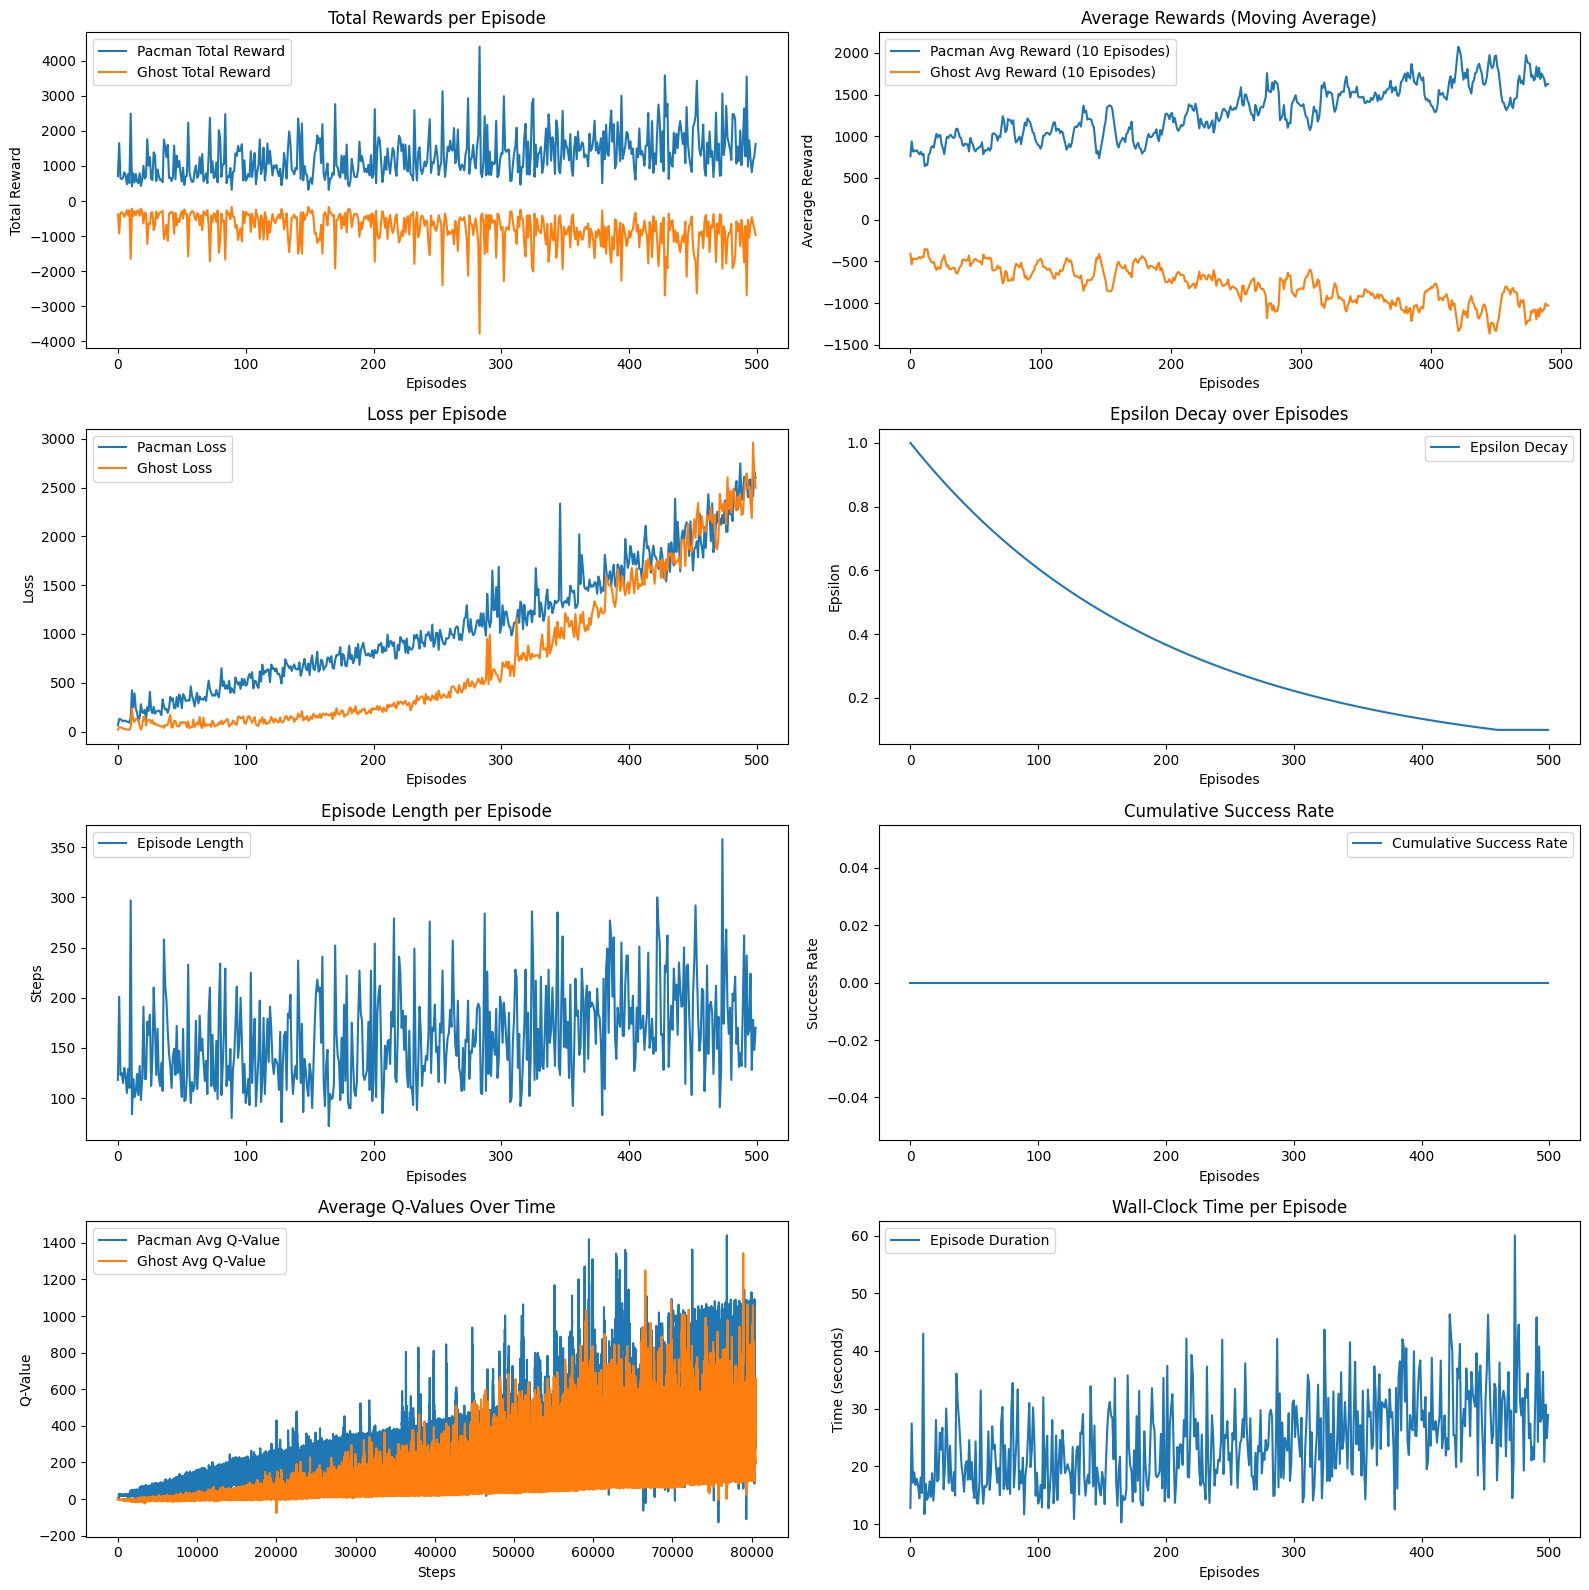

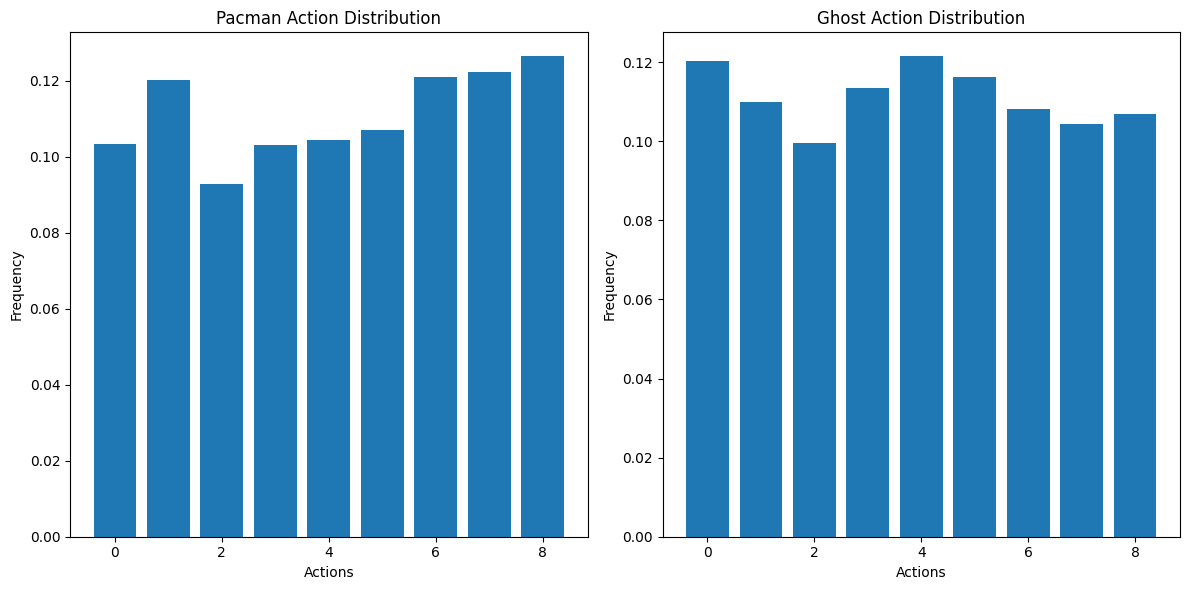

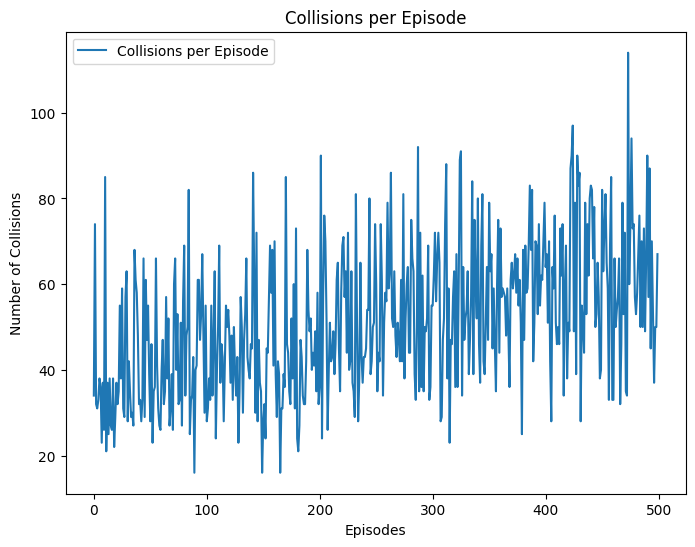

In [7]:
plot_all_metrics(metrics)